# **Book Recommendation System**

## **1. Overview**

### 1.1 Data
There are 3 datasets:
- **Books**: contains book information including book title, author, publication year, and publisher.
- **Users**: contains user information including user ID, user location and age if available.
- **Ratings**: contains book rating which is expressed on a scale of 1-10 with higher value indicates higher appreciation.
### 1.2 Objective
- Perform EDA to gain insights into the datasets.
- Create algorithm to reccomend book to users.



## **2. Prepare Data**

In [47]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


### 2.1 Books Dataset

In [48]:
# Load data
books = pd.read_csv("Books.csv", usecols=[0,1,2,3,4])

# Inspect data
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [49]:
# Data info
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


Notice that column year-of-publication is of object type, which should be converted to integer type.

There are some null values but we will leave it as it is.

In [50]:
# Convert year of publication to integer
book = books.copy()
# Cooerce the conversion will return NaN value if value cannot be converted into numerical value
book['Year-Of-Publication'] = pd.to_numeric(book['Year-Of-Publication'], errors='coerce')

# Find all the rows that year of publication is not an integer
books[book['Year-Of-Publication'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


There are 3 data points where the values of book author, year of publication and publisher are mismatched.\
To fix this, we move the value from book author to year of publication and year of publication to publisher. Also, the author name is concatenated at the end of the book-title so we will extract this information and put it in the correct column.

In [51]:
mask = books['Year-Of-Publication'].isin(['DK Publishing Inc','Gallimard'])

# Extract the book-author from book-title
authors = []
titles = []
for title in books.loc[mask,'Book-Title']:  
    author = title.split(';')[-1].split('"')[0]
    book_title = title.split(';')[0].split('\\')[0]

    authors.append(author)
    titles.append(book_title)

# Switch the values
books.loc[mask, ['Year-Of-Publication', 'Publisher']] = books.loc[mask, ['Book-Author', 'Year-Of-Publication']].values
books.loc[mask, 'Book-Author']  = authors
books.loc[mask, 'Book-Title'] = titles

# Convert Year Of Publication column to integer type
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'])

books[books['ISBN'].isin(['078946697X','2070426769','0789466953'])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc


### 2.2 Users Dataset

In [52]:
# Load data
users = pd.read_csv("Users.csv")

# Inpsect data
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [53]:
# Users info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


There are 110762 missing values in age column out of 278858 values. Since we will use content-based filtering based on book information so we can leave the missing value as it is.

### 2.3 Ratings Dataset


In [54]:
# Load data
ratings = pd.read_csv("Ratings.csv")

# Inpsect data
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [55]:
# Ratings info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [56]:
# Confirm that every user id in ratings dataset also exist in user dataset
len(ratings[~ratings['User-ID'].isin(users['User-ID'])]['User-ID'].unique()) == 0

True

## **3. Exploratory Data Analysis (EDA)**

In [57]:
# Find number of ratings and average rating per each book
ratings_count = ratings.groupby('ISBN').count()[['User-ID']].rename(columns={'User-ID': 'Num Ratings'})
avg_rating = ratings.groupby('ISBN')['Book-Rating'].mean().rename('Avg Rating')
book_with_ratings = books.merge(ratings_count, on='ISBN', how='left').merge(avg_rating, on='ISBN', how='left')
book_with_ratings.head()

book_with_ratings['Num Ratings'] = book_with_ratings['Num Ratings'].fillna(0)
book_with_ratings['Avg Rating'] = book_with_ratings['Avg Rating'].fillna(0)

# Convert ratings_count to integer
book_with_ratings['Num Ratings'] = book_with_ratings['Num Ratings'].astype(int)


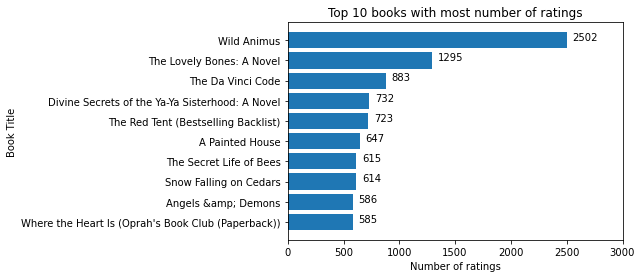

In [58]:
# Top 10 books with most ratings
top_10_most_ratings = book_with_ratings.nlargest(10, 'Num Ratings')
plt.barh(top_10_most_ratings['Book-Title'], top_10_most_ratings['Num Ratings'])
plt.gca().invert_yaxis()
plt.xlabel('Number of ratings')
plt.ylabel('Book Title')
plt.title('Top 10 books with most number of ratings')
plt.gca().set_xlim([0, 3000])

for i, v in enumerate(top_10_most_ratings['Num Ratings']):
    plt.text(v + 50, i, str(v), color='black')
    
plt.show()

To find books with highest ratings, we need to consider that a book can be rated highly but only have 1 or 2 readers rating it. To address this issue, we will introduce a weighted rating score (Bayesian average) which can be computed as:

Weighted rating score = $(v/(v+m)) * R + (m/ (v+m)) * C$

where
* R = average rating of the book
* v = number of ratings of the book
* m = minimum number of ratings required for book to be considered (10 for this case)
* C = average rating across all books in the dataset

In [59]:
# Caclulate average rating across all books
avg_ratings = ratings['Book-Rating'].mean()

# Caculate the weighted rating score for each book
m = 10
book_with_ratings['Score'] = (book_with_ratings['Num Ratings'] / (book_with_ratings['Num Ratings'] + m)) * book_with_ratings['Avg Rating'] + (m / (book_with_ratings['Num Ratings'] + m)) * avg_ratings


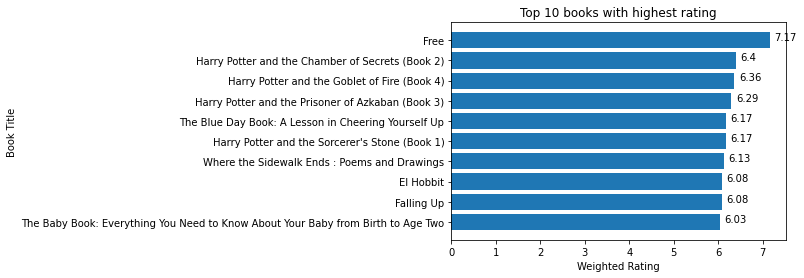

In [60]:
# Top 10 books with highest weighted rating score
top_10_highest_ratings = book_with_ratings.nlargest(10, 'Score')
plt.barh(top_10_highest_ratings['Book-Title'], top_10_highest_ratings['Score'])
plt.gca().invert_yaxis()
plt.xlabel('Weighted Rating')
plt.ylabel('Book Title')
plt.title('Top 10 books with highest rating')

for i, v in enumerate(top_10_highest_ratings['Score']):
    plt.text(v + 0.1, i, str(round(v,2)), color='black')
    
plt.show()

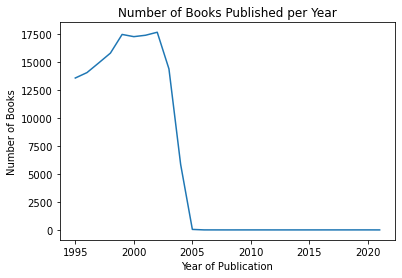

In [61]:
# Relationship between year published and number of books published
# Filter the books dataset to consider only books published between 1995 and 2023
filtered_year = books[books['Year-Of-Publication'].between(1995, 2023)]

# Group the filtered books by publication year and count the number of books
book_counts = filtered_year.groupby('Year-Of-Publication').count()

# Plot the line chart
plt.plot(book_counts.index, book_counts['ISBN'])
plt.xlabel('Year of Publication')
plt.ylabel('Number of Books')
plt.title('Number of Books Published per Year')

plt.show()

No trend or pattern identified between the year of publication and number of books published.

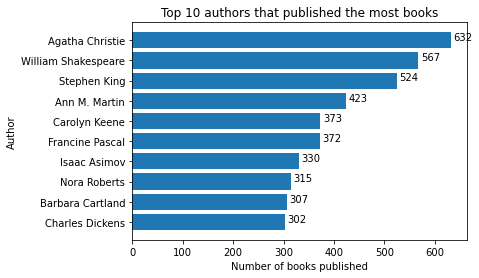

In [62]:
author_stats = book_with_ratings.groupby('Book-Author').agg(
    Num_Books=('ISBN', 'count'),
    Avg_Rating=('Avg Rating', 'mean'),
    Avg_Score=('Score', 'mean')
).reset_index()

# Top 10 author that published the most books
top_10_author = author_stats.nlargest(10, 'Num_Books')
plt.barh(top_10_author['Book-Author'], top_10_author['Num_Books'])
plt.gca().invert_yaxis()
plt.xlabel('Number of books published')
plt.ylabel('Author')
plt.title('Top 10 authors that published the most books')

for i, v in enumerate(top_10_author['Num_Books']):
    plt.text(v + 5, i, str(v), color='black')
    
plt.show()



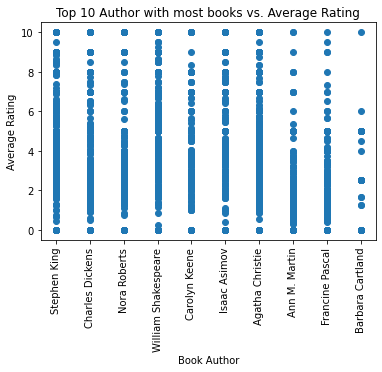

In [63]:
# Find correlation between top authors and ratings
filtered_author_rating = book_with_ratings[book_with_ratings['Book-Author'].isin(top_10_author['Book-Author'])]

plt.scatter(filtered_author_rating['Book-Author'], filtered_author_rating['Avg Rating'])
plt.xlabel('Book Author')
plt.ylabel('Average Rating')
plt.title('Top 10 Author with most books vs. Average Rating')
plt.xticks(rotation=90)
plt.show()

There is no correlation between top 10 authors that published the most books and their book ratings.

### **4. Recommendation System**

### 4.1 Most Popular Books Recommendation

This approach will recommend the most popular books or books with the highest weighted rating to readers.


In [64]:
def popular_books():
    data = {
        'Book': top_10_highest_ratings['Book-Title'],
        'Book-Author': top_10_highest_ratings['Book-Author'],
        'Avg Rating': top_10_highest_ratings['Avg Rating']
    }
    
    return pd.DataFrame(data)
    
rec_book = popular_books()
rec_book

,Book,Book-Author,Avg Rating
3028,Free,Paul Vincent,7.962963
5432,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,6.611765
5431,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,6.541237
3839,Harry Potter and the Prisoner of Azkaban (Book 3),J. K. Rowling,6.467005
79431,The Blue Day Book: A Lesson in Cheering Yourse...,Bradley Trevor Greive,9.181818
2809,Harry Potter and the Sorcerer's Stone (Book 1),J. K. Rowling,6.363095
1101,Where the Sidewalk Ends : Poems and Drawings,Shel Silverstein,7.121212
27556,El Hobbit,J. R. R. Tolkien,7.478261
16190,Falling Up,Shel Silverstein,6.921053
16184,The Baby Book: Everything You Need to Know Abo...,Martha Sears,8.461538


### 4.2 Content Based Recommendation

This approach will recommend books that are similar to ones that readers have rated highly in the past. The recommendation is made based on:

* Book title: readers might be attrcted to a book series.

* Authors: readers might be attracted to specific authors as some authors tend to write about certain genres or famous for certain genres.

* Publisher: readers might prefer credible publisher than less credible one.

We don't consider Year-Of-Publication as feature as there are many datapoints that have value of 0 for year-of-publication. Some even have invalid values (greater than current year 2023). Also, some books can be republished by different publishers so publication year might not be a good feature to consider.



In [65]:
features = ['Book-Title','Book-Author', 'Publisher']
def create_feature(x):
    return str(x['Book-Title']) + ' ' + str(x['Book-Author']) + ' ' + str(x['Publisher'])

# Consider only books that have more than 10 ratings
filtered_book = book_with_ratings[book_with_ratings['Num Ratings'] > 10].copy()
filtered_book.loc[:,'Features'] = filtered_book.loc[:,features].apply(create_feature, axis = 1)

df2 = filtered_book.reset_index()
indices = pd.Series(df2.index, index=df2['ISBN'])


In [66]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
count_matrix = vectorizer.fit_transform(filtered_book['Features'])

In [67]:
# Compute the Cosine Similarity matrix based on count_matrix
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(count_matrix)


In [68]:
def content_based(book_ISBN, similarity, indices):

    # Get the index of the books that matches the ISBN
    idx = indices[book_ISBN]

    # Get the pairwsie similarity scores of all books with that book
    sim_scores = list(enumerate(similarity[idx]))

    # Sort the books based on the similarity scores and get scores of most 5 similar books
    sim_books = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]

    # Get the book indices
    book_indices = [i[0] for i in sim_books]

    # Return the top 5 most similar books
    return df2[['Book-Title', 'Book-Author','Avg Rating']].iloc[book_indices]


def content_based_filter(userid, similarity, ratings, filtered_book, indices):
    filtered_rating = ratings[ratings['User-ID'] == userid]
    books_read = list(filtered_rating['ISBN'].tolist())
    # Get all the top 10 books with highest ratings 
    available_books = filtered_book.nlargest(10, 'Score')
    available_books = available_books[~available_books['ISBN'].isin(books_read)]

    # If user hasn't rated any books, recommend books based on top 10 highest rated book
    if filtered_rating.empty:    
        df_recommend = popular_books()
    else:
        # Find the book that user rated highest
        book_ISBN = filtered_rating.loc[filtered_rating['Book-Rating'].idxmax(), 'ISBN']
        # Check if book_ISBN exists in filtered_book. If not, recommend based on the other books user read
        if book_ISBN not in filtered_book['ISBN'].values:
            filtered_books_read = filtered_book[filtered_book['ISBN'].isin(books_read)]
            if filtered_books_read.empty:
                df_recommend = popular_books()
            else:
                book_ISBN = filtered_books_read.iloc[0]['ISBN']
                recommendation = content_based(book_ISBN, similarity, indices)
                df_recommend = pd.DataFrame(recommendation)
        else:
            recommendation = content_based(book_ISBN, similarity, indices)
            df_recommend = pd.DataFrame(recommendation)


    return df_recommend



In [69]:
# For example, given user id = 274618, below is the list that the user has read and rated
filtered_rating = ratings[ratings['User-ID'] == 274618]
books_read = list(filtered_rating['ISBN'].tolist())
books.merge(ratings[(ratings['User-ID'] == 274618) & (ratings['ISBN'].isin(books_read))], on='ISBN')

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating
0,0064407667,The Bad Beginning (A Series of Unfortunate Eve...,Lemony Snicket,1999,HarperCollins,274618,10
1,0394820371,The Phantom Tollbooth,Norton Juster,1993,Yearling Books,274618,0
2,0590457225,Dealing With Dragons (Enchanted Forest Chronic...,Patricia C. Wrede,1992,Scholastic,274618,0
3,0439064872,Harry Potter and the Chamber of Secrets (Book 2),J. K. Rowling,2000,Scholastic,274618,10
4,0064407675,The Reptile Room (A Series of Unfortunate Even...,Lemony Snicket,1999,HarperCollins,274618,10
5,0441005489,"Redwall (Redwall, Book 1)",Brian Jacques,1998,Ace Books,274618,0
6,0553274295,Where the Red Fern Grows,Wilson Rawls,1984,Random House Children's Books,274618,10
7,0060256737,A Light in the Attic,Shel Silverstein,1981,HarperCollins,274618,10
8,0141301058,The BFG,Roald Dahl,1998,Puffin Books,274618,0
9,0737399368,Tales of the Great White,Jocelyn Heaney,0,Lowell House Juvenile,274618,10


In [70]:
rec_books = content_based_filter(274618, similarity, ratings, filtered_book, indices)
rec_books

,Book-Title,Book-Author,Avg Rating
5305,The Giving Tree,Shel Silverstein,5.571429
6128,Falling Up,Shel Silverstein,6.921053
570,Where the Sidewalk Ends : Poems and Drawings,Shel Silverstein,7.121212
6496,The Castle in the Attic,ELIZABETH WINTHROP,2.176471
5739,The Light in the Forest,Conrad Richter,1.588235


Since the user (274618) rated 10 for 'A Light in the Attic' by Shel Silverstein, the recommendation system suggests books from the same author.\
The recommendation system could be improved further if the dataset contains genre or short summary of the book.

### 4.3 Item-based Collaborative Filtering

Collaborative filtering is a technique that helps in recommending items to a user based on the preferences and behaviors of similar users.

- **Item-based**: This approach looks for similarities between items based on how they have been rated by users. It identifies items that have been rated similarly by users and uses these patterns to make recommendations. The similarity between items is measured based on user ratings, and recommendations are made based on the items that are similar to the ones the target user has rated.


In [71]:
# Classify books as common and rare
# Common books are books with more than 20 ratings
common_book = book_with_ratings[book_with_ratings['Num Ratings'] > 20]
rare_book = book_with_ratings[ ~book_with_ratings['ISBN'].isin(common_book['ISBN'])]
common_book = ratings[ratings['ISBN'].isin(common_book['ISBN'])].merge(book_with_ratings.loc[:,['ISBN', 'Book-Title']], on='ISBN')
common_book.head()


,User-ID,ISBN,Book-Rating,Book-Title
0,276725,034545104X,0,Flesh Tones: A Novel
1,2313,034545104X,5,Flesh Tones: A Novel
2,6543,034545104X,0,Flesh Tones: A Novel
3,8680,034545104X,5,Flesh Tones: A Novel
4,10314,034545104X,9,Flesh Tones: A Novel


In [72]:
# Create a pivot table from the common_book dataframe
pivot_table = common_book.pivot(index='User-ID',columns='ISBN',values='Book-Rating')
pivot_table.head()

ISBN,000649840X,0006547834,0006550576,0006550789,0007110928,0007141076,0007154615,0020198817,0020198906,0020199600,...,880781210X,8807813025,8817106100,8817106259,8817131628,8845205118,8845247414,884590184X,8885989403,950491036X
User-ID,,,,,,,,,,,,,,,,,,,,,
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [73]:
def item_based_coll_filter(book_title, common_book, rare_book, book_with_ratings, item_based, N = 10):
    
    book_title = str(book_title)

    matching_books = book_with_ratings[book_with_ratings['Book-Title'] == book_title]
    book_ISBN = matching_books.loc[matching_books['Num Ratings'].idxmax(), 'ISBN']

    # Check if book is within the book dataset. If not, recommend popular books
    if book_title in book_with_ratings['Book-Title'].values:
        # Some books are republished so even with different ISBN, the book has same name.
        if book_title in rare_book['Book-Title'].values and book_title not in common_book['Book-Title'].values:
            print('A rare book, so u may try our popular books:')
            rec_books = popular_books()
        else:
            sim = item_based[book_ISBN]
            recommendation_df = pd.DataFrame(item_based.corrwith(sim).sort_values(ascending=False)).reset_index(drop=False)

            # Check if the book that user choosen is included in the recommendation
            # If it is included we exclude it
            if book_ISBN in recommendation_df['ISBN'].values:
                recommendation_df = recommendation_df[recommendation_df['ISBN'] != book_ISBN]

            # Exclude from the recommendation list books that are not highly rated (average rating < 5)
            average_ratings = common_book.groupby('ISBN')['Book-Rating'].mean()
            recommendation_df = recommendation_df.merge(average_ratings, on='ISBN')
            recommendation_df = recommendation_df[recommendation_df['Book-Rating'] >= 5]

            # Only keep books with correlation > correlation threshold of 0.7
            recommendation_df.columns=['ISBN','Correlation', 'Avg Rating']
            recommendation_df = recommendation_df[recommendation_df['Correlation'] > 0.7].drop("Correlation", axis=1)
            
            # Get the final recommendation
            recommendation_df = recommendation_df.merge(common_book.loc[:,['ISBN','Book-Title']], on='ISBN').drop_duplicates(subset='ISBN')
            recommendation_df = recommendation_df.reindex(columns=['ISBN', 'Book-Title', 'Avg Rating'])
            if len(recommendation_df) < N:
                rec_books= recommendation_df
            else:
                rec_books= recommendation_df.head(N)
    else:
        print("This book is not in our library, check out our most popular books:")
        rec_books = popular_books()

    return rec_books


We will now try to recommend 5 books that are rated in a similar manner to 'Harry Potter and the Chamber of Secrets (Book 2)'

In [74]:
item_based_coll_filter('Harry Potter and the Chamber of Secrets (Book 2)', common_book, rare_book, book_with_ratings, pivot_table, 5)

,ISBN,Book-Title,Avg Rating
0,0345435273,A Caress of Twilight (Meredith Gentry Novels (...,5.166667
30,0345272579,The Hobbit,5.454545
52,0066238501,Complete Chronicles of Narnia,5.862069
81,0930289234,Watchmen,5.272727
103,0061020400,The Fifth Elephant: A Novel of Discworld,5.346154


## **5. Conclusion**

The 3 recommendation algorithms discussed above each have their own strengths and weaknesses, and the choice of which algorithm to use depends on the specific users and goals we are targeting.

However, there are still areas where these algorithms can be improved, as well as opportunities to enhance the datasets used. For example, in the case of content-based recommendation, incorporating additional information such as book synopses or genre details could lead to more precise and relevant recommendations. Similarly, trying user-based collaborative filtering, which focuses on the relationships between users and their shared book preferences, could also refine the recommendation.

